In [1]:
# Colab-ready Stacked Ensemble for file2.csv — MLP + LSTM + CNN+BiGRU
# Fixes:
# - No data leakage (preprocessing fit only on train)
# - Class imbalance handled via class weights
# - EarlyStopping monitors AUC (robust for imbalance)
# - Stacking meta-learner learns optimal weights (vs naive average)
# - Threshold tuned on validation for F1 (switchable to MCC/Youden J)
# - log_loss patch for older sklearn (clip probs; no eps kwarg)

# ==========
# Setup
# ==========
import os, sys, warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # reduce TF logging

# If running on Colab and file2.csv not found locally, open upload dialog
csv_name = "file2.csv"
if not os.path.exists(csv_name):
    try:
        from google.colab import files  # type: ignore
        print("Upload file2.csv (AI4I dataset variant used in your notebooks)")
        _ = files.upload()
    except Exception as e:
        print("If you are not in Colab, ensure file2.csv is in the current folder.")
        raise

# ==========
# Imports
# ==========
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, log_loss as _sk_log_loss, matthews_corrcoef, cohen_kappa_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model as KerasModel
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========
# Load & Clean
# ==========
df = pd.read_csv(csv_name)

# Drop known leakage/ID columns used in many AI4I variants (keep only those that exist)
leak_cols = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
drop_cols = [c for c in leak_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

# Ensure target exists and is int
target_col = "Machine failure"
assert target_col in df.columns, f"'{target_col}' not found. Available: {list(df.columns)}"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int).values

# ==========
# Train/Valid/Test Split
# ==========
X_train_full, X_test_raw, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=SEED
)

# ==========
# Preprocessing (fit on train only)
# ==========
cat_cols = X_train_raw.select_dtypes(include="object").columns.tolist()
num_cols = X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()

ohe_kwargs = {"handle_unknown": "ignore"}
# Compatibility across sklearn versions (sparse_output vs sparse)
try:
    OneHotEncoder(sparse_output=False, **ohe_kwargs)
    ohe_kwargs["sparse_output"] = False
except TypeError:
    ohe_kwargs["sparse"] = False

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(**ohe_kwargs)),
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

X_train = preprocessor.fit_transform(X_train_raw)
X_valid = preprocessor.transform(X_valid_raw)
X_test  = preprocessor.transform(X_test_raw)

def to_seq(arr):
    # reshape to (samples, timesteps, channels)
    return arr.reshape((arr.shape[0], arr.shape[1], 1))

X_train_seq = to_seq(X_train)
X_valid_seq = to_seq(X_valid)
X_test_seq  = to_seq(X_test)

input_dim = X_train.shape[1]
seq_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# ==========
# Class Weights for Imbalance
# ==========
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): w for c, w in zip(classes, cw)}

# ==========
# Model Builders
# ==========
def build_mlp(input_dim: int) -> tf.keras.Model:
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape) -> tf.keras.Model:
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn_bigru(input_shape) -> tf.keras.Model:
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding="same", activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(GRU(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return KerasModel(inputs, outputs)

def compile_and_train(model, X_tr, y_tr, X_va, y_va, epochs=100, batch_size=64, cw=class_weight):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 'accuracy']
    )
    es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        class_weight=cw,
        verbose=0
    )
    return model

# ==========
# Train Base Learners on (train) and validate on (valid)
# ==========
mlp = compile_and_train(build_mlp(input_dim), X_train, y_train, X_valid, y_valid)
lstm = compile_and_train(build_lstm(seq_shape), X_train_seq, y_train, X_valid_seq, y_valid)
cnn_bigru = compile_and_train(build_cnn_bigru(seq_shape), X_train_seq, y_train, X_valid_seq, y_valid)

# ==========
# Stacking on Validation
# ==========
valid_preds = np.column_stack([
    mlp.predict(X_valid, verbose=0).ravel(),
    lstm.predict(X_valid_seq, verbose=0).ravel(),
    cnn_bigru.predict(X_valid_seq, verbose=0).ravel(),
])

stacker = LogisticRegression(max_iter=1000, random_state=SEED)
stacker.fit(valid_preds, y_valid)

def tune_threshold(y_true, proba, metric="f1"):
    best_t, best_score = 0.5, -1.0
    for t in np.linspace(0.05, 0.95, 91):
        preds = (proba >= t).astype(int)
        if metric == "f1":
            score = f1_score(y_true, preds)
        elif metric == "mcc":
            score = matthews_corrcoef(y_true, preds)
        else:
            # Youden's J (sensitivity + specificity - 1)
            cm = confusion_matrix(y_true, preds)
            tn, fp, fn, tp = cm.ravel()
            sens = tp / (tp + fn) if (tp + fn) else 0.0
            spec = tn / (tn + fp) if (tn + fp) else 0.0
            score = sens + spec - 1.0
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score

valid_meta_proba = stacker.predict_proba(valid_preds)[:, 1]
best_threshold, best_val_score = tune_threshold(y_valid, valid_meta_proba, metric="f1")

# ==========
# Retrain Base Models on (train+valid), then Evaluate on Test
# ==========
# Refit preprocessor on all train_full (train+valid) for final models
preprocessor_full = preprocessor  # reuse object
preprocessor_full.fit(pd.concat([X_train_raw, X_valid_raw], axis=0))
X_trva = preprocessor_full.transform(pd.concat([X_train_raw, X_valid_raw], axis=0))
y_trva = np.concatenate([y_train, y_valid], axis=0)
X_trva_seq = to_seq(X_trva)

input_dim2 = X_trva.shape[1]
seq_shape2 = (X_trva_seq.shape[1], X_trva_seq.shape[2])

classes2 = np.unique(y_trva)
cw2 = compute_class_weight(class_weight="balanced", classes=classes2, y=y_trva)
class_weight_trva = {int(c): w for c, w in zip(classes2, cw2)}

def compile_and_train_no_valid(model, X_tr, y_tr, epochs=100, batch_size=64, cw=class_weight_trva):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )
    es = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True, verbose=1)
    model.fit(
        X_tr, y_tr,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        class_weight=cw,
        verbose=0
    )
    return model

mlp_final = compile_and_train_no_valid(build_mlp(input_dim2), X_trva, y_trva)
lstm_final = compile_and_train_no_valid(build_lstm(seq_shape2), X_trva_seq, y_trva)
cnn_bigru_final = compile_and_train_no_valid(build_cnn_bigru(seq_shape2), X_trva_seq, y_trva)

# Final test matrices
X_test_final = preprocessor_full.transform(X_test_raw)
X_test_final_seq = to_seq(X_test_final)

test_preds = np.column_stack([
    mlp_final.predict(X_test_final, verbose=0).ravel(),
    lstm_final.predict(X_test_final_seq, verbose=0).ravel(),
    cnn_bigru_final.predict(X_test_final_seq, verbose=0).ravel(),
])

test_meta_proba = stacker.predict_proba(test_preds)[:, 1]
test_meta_pred = (test_meta_proba >= best_threshold).astype(int)

# ==========
# Metrics (with log_loss patch)
# ==========
def compute_metrics(y_true, y_pred, y_proba):
    # clip to avoid log(0) for sklearn versions without eps kwarg
    y_proba = np.clip(np.asarray(y_proba, dtype=float), 1e-7, 1 - 1e-7)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": specificity,
        "AUC": roc_auc_score(y_true, y_proba),
        "Log Loss": _sk_log_loss(y_true, y_proba),  # no eps kwarg
        "MCC": matthews_corrcoef(y_true, y_pred),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "Misclassification Error": (fp + fn) / (tp + tn + fp + fn)
    }
    return metrics, cm

metrics, cm = compute_metrics(y_test, test_meta_pred, test_meta_proba)

print("\n--- Ensemble (Stacked) Evaluation on Test ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"Chosen threshold (from validation): {best_threshold:.3f}  |  Valid-F1 at threshold: {best_val_score:.4f}")
print("Confusion matrix [tn, fp; fn, tp]:\n", cm)

# AUCs of base learners vs stacked ensemble (on test)
mlp_auc  = roc_auc_score(y_test, test_preds[:, 0])
lstm_auc = roc_auc_score(y_test, test_preds[:, 1])
cnn_auc  = roc_auc_score(y_test, test_preds[:, 2])
ens_auc  = roc_auc_score(y_test, test_meta_proba)

print("\nAUCs — MLP: {:.4f} | LSTM: {:.4f} | CNN+BiGRU: {:.4f} | Stacked Ensemble: {:.4f}".format(
    mlp_auc, lstm_auc, cnn_auc, ens_auc
))

# ==========
# Notes / Switches
# ==========
# - If your "Novel_CNN+GRU" uses plain GRU (not BiGRU), swap build_cnn_bigru() with GRU(...) (non-bidirectional).
# - To optimize MCC instead of F1 for thresholding, change: tune_threshold(..., metric="mcc").
# - If your CSV differs (column names), print(df.columns) and adjust 'leak_cols' + 'target_col' accordingly.


Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 51.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 29.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 64.
Restoring model weights from the end of the best epoch: 99.
Restoring model weights from the end of the best epoch: 98.

--- Ensemble (Stacked) Evaluation on Test ---
Accuracy: 0.9825
F1 Score: 0.7200
Precision: 0.7895
Recall: 0.6618
Specificity: 0.9938
AUC: 0.9795
Log Loss: 0.0611
MCC: 0.7140
Kappa: 0.7110
Misclassification Error: 0.0175
Chosen threshold (from validation): 0.420  |  Valid-F1 at threshold: 0.6990
Confusion matrix [tn, fp; fn, tp]:
 [[1920   12]
 [  23   45]]

AUCs — MLP: 0.9770 | LSTM: 0.9631 | CNN+BiGRU: 0.9718 | Stacked Ensemble: 0.9795


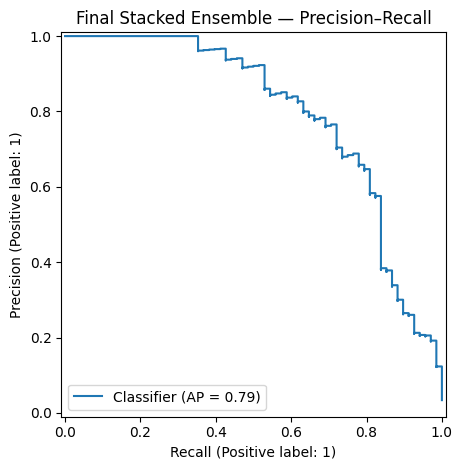

ExactExplainer explainer: 1025it [1:06:12,  3.88s/it]


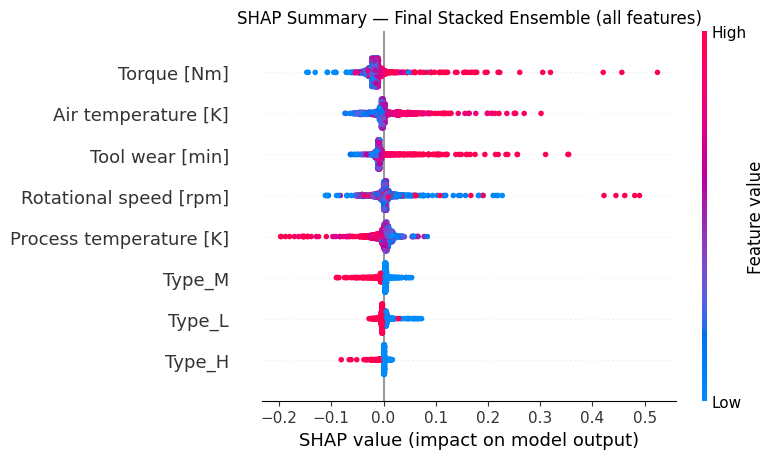

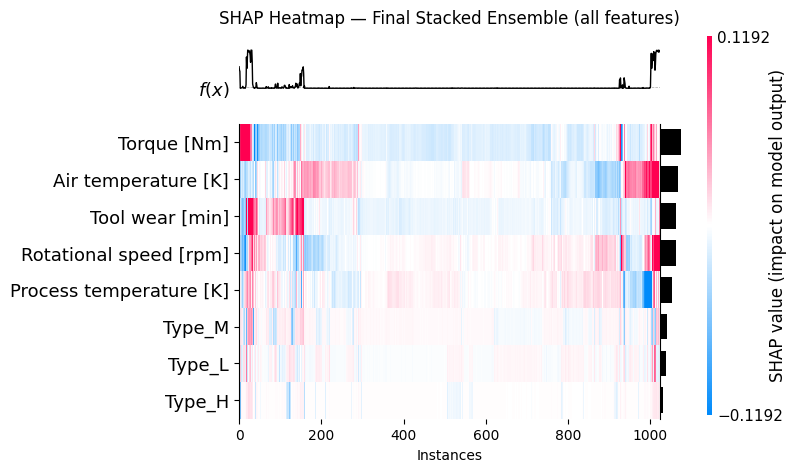

Saved: Results/stacked_final_pr.pdf, Results/shap_beeswarm_stacked_all_features.pdf, Results/shap_heatmap_stacked_all_features.pdf


In [4]:
# ===== Stacked Ensemble: PR + SHAP (summary & heatmap) on ALL input features (proper names) =====
# Explains the final ensemble w.r.t. the preprocessed feature space (numeric + OHE columns),
# and prints real feature names instead of "feature 0/1/...".
!pip -q install shap==0.46.0

import os, numpy as np, matplotlib.pyplot as plt, warnings
import shap
from sklearn.metrics import PrecisionRecallDisplay
warnings.filterwarnings("ignore")

# ------------------ Checks ------------------
need = ["preprocessor_full", "X_test_raw", "y_test",
        "mlp_final", "lstm_final", "cnn_bigru_final", "stacker",
        "test_meta_proba"]
missing = [v for v in need if v not in globals()]
assert not missing, f"Missing variables: {missing}. Run the training block first."

# ------------------ Get full feature names from the fitted preprocessor ------------------
def get_feature_names_from_preprocessor(preprocessor, num_cols, cat_cols):
    """
    Robustly extract feature names after ColumnTransformer with:
      - numeric pipeline: SimpleImputer + StandardScaler (names = original num cols)
      - categorical pipeline: SimpleImputer + OneHotEncoder (names include categories)
    Falls back to generic f0.. if unavailable.
    """
    names = None
    # Try sklearn >= 1.0 unified output
    try:
        names = list(preprocessor.get_feature_names_out())
        # These may look like 'num__colname' / 'cat__colname_category'; clean up a bit:
        names = [n.replace("num__", "").replace("cat__", "") for n in names]
        return names
    except Exception:
        pass

    # Manual extraction
    num_names = list(num_cols) if num_cols is not None else []
    cat_names = []
    try:
        # Find the OneHotEncoder inside the 'cat' transformer
        cat_transformer = None
        for name, trans, cols in preprocessor.transformers_:
            if name == "cat":
                # 'trans' is a Pipeline; last step should be OneHotEncoder
                for step_name, step in getattr(trans, "steps", []):
                    if hasattr(step, "get_feature_names_out"):
                        ohe = step
                        ohe_out = list(ohe.get_feature_names_out(input_features=cols))
                        cat_names = [n.replace("_", "=") for n in ohe_out]  # readable labels
                break
    except Exception:
        pass

    if num_names or cat_names:
        return num_names + cat_names

    # Fallback: generic
    # We need to know the final transformed shape to build f0.. names;
    # try transforming a single row from X_test_raw:
    try:
        X_tmp = preprocessor.transform(X_test_raw.iloc[:1])
        return [f"f{i}" for i in range(X_tmp.shape[1])]
    except Exception:
        return None

# Extract original column lists from your earlier split (re-derive from X_test_raw dtypes)
num_cols_all = X_test_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_all = X_test_raw.select_dtypes(include="object").columns.tolist()
FEATURE_NAMES = get_feature_names_from_preprocessor(preprocessor_full, num_cols_all, cat_cols_all)

# ------------------ Build a predictor over the PREPROCESSED feature space ------------------
# We’ll accept X_pre (2D, already preprocessed by preprocessor_full),
# feed it to (mlp_final on 2D) and (lstm_final/cnn_bigru_final on 3D reshaped), then stacker.
def ensemble_prob_from_preprocessed(X_pre_2d):
    # X_pre_2d: shape (n, P)
    # MLP works on 2D directly:
    p_mlp  = mlp_final.predict(X_pre_2d, verbose=0).ravel()
    # Sequence models need (n, P, 1)
    X_seq = X_pre_2d.reshape((X_pre_2d.shape[0], X_pre_2d.shape[1], 1))
    p_lstm = lstm_final.predict(X_seq, verbose=0).ravel()
    p_cnn  = cnn_bigru_final.predict(X_seq, verbose=0).ravel()
    meta   = np.column_stack([p_mlp, p_lstm, p_cnn])
    return stacker.predict_proba(meta)[:, 1]

# Convenience for SHAP: wrap a function that accepts PREPROCESSED arrays
def make_shap_predictor():
    # Directly use the function above
    return lambda X: ensemble_prob_from_preprocessed(np.asarray(X))

# ------------------ Data for PR & SHAP ------------------
# PR uses your already-computed final ensemble probabilities on the test set:
y_true = y_test
y_prob = np.asarray(test_meta_proba).ravel()

# For SHAP, we need the PREPROCESSED (2D) test matrix and a background set
X_test_pre  = preprocessor_full.transform(X_test_raw)  # shape (n_test, P)
# Use train+valid preprocessed if you kept it; otherwise sample from test
X_bg_source = globals().get("X_trva", None)
if X_bg_source is None:
    # build from train+valid raw if present
    if "X_train_raw" in globals() and "X_valid_raw" in globals():
        X_bg_source = preprocessor_full.transform(
            __import__("pandas").concat([X_train_raw, X_valid_raw], axis=0)
        )
    else:
        X_bg_source = X_test_pre  # fallback

rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X_bg_source), size=min(200, len(X_bg_source)), replace=False)
X_bg   = X_bg_source[bg_idx]

# Limit eval size for speed
X_eval = X_test_pre[: min(1024, len(X_test_pre))]

# ------------------ Precision–Recall (Final Ensemble) ------------------
os.makedirs("Results", exist_ok=True)
PrecisionRecallDisplay.from_predictions(y_true, y_prob)
plt.title("Final Stacked Ensemble — Precision–Recall")
plt.tight_layout()
plt.savefig("Results/stacked_final_pr.pdf", bbox_inches="tight")
plt.show()

# ------------------ SHAP (Summary + Heatmap) with REAL feature names ------------------
predict_fn = make_shap_predictor()
masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(predict_fn, masker)

exp = explainer(X_eval)

# SHAP Summary (beeswarm) — show real feature names
try:
    shap.plots.beeswarm(
        shap.Explanation(values=exp.values, data=exp.data, feature_names=FEATURE_NAMES),
        show=False
    )
except Exception:
    shap.summary_plot(exp.values, features=exp.data, feature_names=FEATURE_NAMES, show=False)
plt.title("SHAP Summary — Final Stacked Ensemble (all features)")
plt.tight_layout()
plt.savefig("Results/shap_beeswarm_stacked_all_features.pdf", bbox_inches="tight")
plt.show()

# SHAP Heatmap — show real feature names (top display automatically handled by shap.heatmap)
try:
    shap.plots.heatmap(
        shap.Explanation(values=exp.values, data=exp.data, feature_names=FEATURE_NAMES),
        max_display=min(100, exp.data.shape[1]), show=False
    )
    plt.title("SHAP Heatmap — Final Stacked Ensemble (all features)")
    plt.tight_layout()
    plt.savefig("Results/shap_heatmap_stacked_all_features.pdf", bbox_inches="tight")
    plt.show()
except Exception:
    # Fallback: simple heatmap with feature labels
    vals = np.asarray(exp.values)
    vals2d = vals if vals.ndim == 2 else vals.reshape(vals.shape[0], -1)
    order = np.argsort(np.abs(vals2d).mean(axis=0))[::-1][: min(100, vals2d.shape[1])]
    plt.imshow(vals2d[:, order].T, aspect="auto")
    ytick_names = [FEATURE_NAMES[i] if FEATURE_NAMES else f"f{i}" for i in order]
    plt.yticks(range(len(order)), ytick_names)
    plt.xlabel("Samples"); plt.ylabel("Top features")
    plt.title("SHAP Heatmap — Final Stacked Ensemble (fallback)")
    plt.tight_layout()
    plt.savefig("Results/shap_heatmap_stacked_all_features.pdf", bbox_inches="tight")
    plt.show()

print("Saved:",
      "Results/stacked_final_pr.pdf,",
      "Results/shap_beeswarm_stacked_all_features.pdf,",
      "Results/shap_heatmap_stacked_all_features.pdf")

